# TODO
- kodowanie cykliczne dla key
- K-means
- metoda mini batch???
- DBSCAN
- GMM


In [356]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import random

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN

from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import silhouette_score,davies_bouldin_score,calinski_harabasz_score

import re
# pip install nltk
import nltk
from collections import defaultdict

nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bartekb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bartekb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# data preparation

after tests we have decided to do some changes in data preprocessingbb

cyclical key encoding doesnt work

In [396]:
def split_artists(df, artist_col='artist(s)_name'):
    df_expanded = df.copy()
    df_expanded[artist_col] = df_expanded[artist_col].str.split(',')
    df_expanded = df_expanded.explode(artist_col)
    df_expanded[artist_col] = df_expanded[artist_col].str.lower().str.replace(' ', '')
    return df_expanded.reset_index(drop=True)
def calculate_mean_streams(df, artist_col='artist(s)_name', streams_col='streams'):
    mean_streams = df.groupby(artist_col)[streams_col].mean()
    return mean_streams.to_dict()
def process_artists(df, artist_avg_streams, artist_col='artist(s)_name', artist_count_col='artist_count'):
    def get_top_artist(artists, artist_avg_streams):
        artists = [artist.lower().replace(' ', '') for artist in artists]
        valid_artists = [artist for artist in artists if artist in artist_avg_streams]
        if valid_artists:
            top_artist = max(valid_artists, key=lambda artist: artist_avg_streams[artist])
        else:
            top_artist = random.choice(artists)
        return top_artist
    processed_df = df.copy()
    for i, row in processed_df.iterrows():
        artists = row[artist_col].split(',')
        top_artist = get_top_artist(artists, artist_avg_streams)
        processed_df.at[i, artist_col] = top_artist
            
    return processed_df
def assign_artist_popularity(df, artist_avg_streams, artist_col='artist(s)_name'):
    # Calculate the four quantiles for the dictionary values
    quantiles = pd.qcut(list(artist_avg_streams.values()), 4, labels=False, retbins=True)[1]
    
    # Function to assign popularity based on quantiles
    def get_popularity(artist, artist_avg_streams, quantiles):
        artist = artist.lower().replace(' ', '')
        avg_streams = artist_avg_streams.get(artist, None)
        if avg_streams is not None:
            if avg_streams <= quantiles[1]:
                return 1
            elif avg_streams <= quantiles[2]:
                return 2
            elif avg_streams <= quantiles[3]:
                return 3
            else:
                return 4
        else:
            return 1  # Assign 1 if artist is not in the dictionary
    
    # Create a new column 'artist_popularity' and assign values based on quantiles
    df['artist_popularity'] = df[artist_col].apply(lambda artist: get_popularity(artist, artist_avg_streams, quantiles))
    
    return df


def preprocess_data(df):
    
    # handle incorrect data ande missing values
    non_numeric_indexes = df[df['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df.loc[non_numeric_indexes, 'streams'] = None
    df['streams'].fillna(524376116,inplace=True)
    df['streams'] = df['streams'].astype(float)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].str.replace(',', '', regex=False)
    df['in_deezer_playlists'] = df['in_deezer_playlists'].astype(int)
    df['in_shazam_charts'] = df['in_shazam_charts'].str.replace(',', '', regex=False)
    df['in_shazam_charts'] = df['in_shazam_charts'].astype(float)
    df['key'].fillna('G',inplace=True)

    # encode categorical variables
    key_order = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', np.nan]
    ordinal_encoder = OrdinalEncoder(categories=[key_order], handle_unknown='use_encoded_value', unknown_value=-1)
    df['key'] = df['key'].astype(object)
    encoded_keys = ordinal_encoder.fit_transform(df[['key']])
    df['key'] = encoded_keys
    # cyclically encode key
    max_value = 11
    #df['key' + '_sin'] = np.sin(2 * np.pi * df['key'] / max_value)
    #df['key' + '_cos'] = np.cos(2 * np.pi * df['key'] / max_value)

    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(['Major', 'Minor'])
    df['mode'] = label_encoder.fit_transform(df['mode'])

    #df['month_sin'] = np.sin(2 * np.pi * df['released_month'] / 12)
    #df['day_sin'] = np.sin(2 * np.pi * df['released_day'] / 31)

    bins = [float('-inf'), 1989, 1999, 2010, 2015, 2019, 2020, 2021, 2022, 2023]
    labels = ['1930-1989', '1990-1999', '2000-2010', '2011-2015', '2016-2019', '2020', '2021', '2022', '2023']
    df['year_group'] = pd.cut(df['released_year'], bins=bins, labels=labels, right=True, include_lowest=True)
    ordinal_mapping = {label: idx for idx, label in enumerate(labels)}
    df['year_group_encoded'] = df['year_group'].map(ordinal_mapping)

    # as for now we will not use 'track name' column

    #assign artist popularity
    df2 = pd.read_csv('../Data/spotify_modelling.csv')
    non_numeric_indexes = df2[df2['streams'].astype(str).str.contains('[a-zA-Z]')].index
    df2.loc[non_numeric_indexes, 'streams'] = None
    df2['streams'].fillna(524376116,inplace=True)
    df2['streams'] = df2['streams'].astype(float)
    pop = calculate_mean_streams(split_artists(df2))
    df = process_artists(df,pop)
    df = assign_artist_popularity(df,pop)

    # Normalize numeric columns
    #cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%', 'key', 'year_group_encoded', 'artist_popularity']
    cols_to_normalize =['streams','in_spotify_charts','in_spotify_playlists','bpm','danceability_%','valence_%','energy_%','acousticness_%','instrumentalness_%','liveness_%','speechiness_%','key','year_group_encoded', 'artist_popularity']
    
    df['mode'] = df['mode']/3
    scaler = MinMaxScaler()
    df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])
    df['streams'] =np.log1p(df.streams)
    df['in_spotify_charts'] =np.log1p(df.in_spotify_charts)
    df['in_spotify_playlists'] =np.log1p(df.in_spotify_playlists)
    #df['acousticness_%'] =df.acousticness_%*2
    
    # drop unnecessary columns
    df.drop(columns=['mode','streams','in_spotify_charts','in_spotify_playlists','year_group','in_apple_charts' ,'in_shazam_charts', 'in_deezer_charts','in_apple_playlists','in_deezer_playlists','artist(s)_name','track_name','artist_count','released_year','released_month','released_day'],axis='columns',inplace=True)

    return df
    

In [390]:
df = pd.read_csv('../Data/spotify_modelling.csv')
df = preprocess_data(df)
df.describe()

bpm         key  danceability_%   valence_%    energy_%  \
count  667.000000  667.000000      667.000000  667.000000  667.000000   
mean     0.403298    0.519190        0.611965    0.517177    0.628356   
std      0.198438    0.302031        0.207287    0.252763    0.185191   
min      0.000000    0.000000        0.000000    0.000000    0.000000   
25%      0.234043    0.300000        0.472222    0.311828    0.511364   
50%      0.390071    0.600000        0.638889    0.516129    0.647727   
75%      0.531915    0.700000        0.763889    0.720430    0.772727   
max      1.000000    1.000000        1.000000    1.000000    1.000000   

       acousticness_%  instrumentalness_%  liveness_%  speechiness_%  \
count      667.000000          667.000000  667.000000     667.000000   
mean         0.274672            0.016309    0.158681       0.143113   
std          0.266828            0.089860    0.143810       0.171604   
min          0.000000            0.000000    0.000000       0.000000   
25%          0.061856            0.000000    0.063830       0.035088   
50%          0.175258            0.000000    0.095745       0.070175   
75%          0.422680            0.000000    0.212766       0.166667   
max          1.000000            1.000000    1.000000       1.000000   

       year_group_encoded  artist_popularity  
count          667.000000         667.000000  
mean             0.743066           0.627686  
std              0.260881           0.331043  
min              0.000000           0.000000  
25%              0.625000           0.333333  
50%              0.875000           0.666667  
75%              0.875000           1.000000  
max              1.000000           1.000000

plan :
- define functions to do pca and tsne visualizations
- pick metric to evaluate models with 
- test and pick best params for models:
**Kmeans, hierarchical clustering, dbscan, gmm**
- pick best one

## Visualization functions

In [374]:
def pca_visualization(df,clusters):
    pca = PCA(n_components=2)  
    X_pca = pca.fit_transform(df)
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=clusters, palette='tab20', legend='full')
    plt.title('K-means Clustering (PCA Visualization)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

In [375]:
def tsne_visualization(dataframe, predicted_clusters):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(dataframe)
    tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
    tsne_df['Cluster'] = predicted_clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='TSNE1', y='TSNE2',
        hue='Cluster',
        palette=sns.color_palette('hsv', len(set(predicted_clusters))),
        data=tsne_df,
        legend='full',
        alpha=0.7
    )
    plt.title('t-SNE Visualization of Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster')
    plt.show()

In [398]:
def interprete_clusters(df,clusters):
    df2 =  df.copy()
    df2['cluster'] = clusters 
    c =df2.groupby('cluster').agg('mean')
    return c

## Metrics

During hyperparameter optimalization we will evaluate model by these metrics:
- Silhouette score
- Davies-Bouldin score
- Caliński-Harabasz score

we will also take in account our subjective opinion about how well songs are clustered

In [376]:
def metrics(df,model):
    clusters = model.fit_predict(df)
    if len(set(clusters)) < 2:
        return [float('-inf'),float('inf'),float('-inf')]
    silhouette = silhouette_score(df,clusters)
    bouldin = davies_bouldin_score(df,clusters) 
    harabasz = calinski_harabasz_score(df,clusters)
    return [silhouette, bouldin, harabasz]

# Hyperparameter tuning

## Kmeans

In kmeans there is one main hyperparameter 
- n_clusters

in KM2 we decided that 5 is optimal, however we suspect that this method will not be the best in this problem, because it favours circel-like clusters and our dataset has some more complex connections

In [401]:
maxi =0
maxsil =-10
for i in range(2,100):
    model = KMeans(n_clusters = 5,random_state=i)
    x = metrics(df,model)
    if x[0]>maxsil:
        maxsil=x[0]
        maxi=i
print(maxi)

14


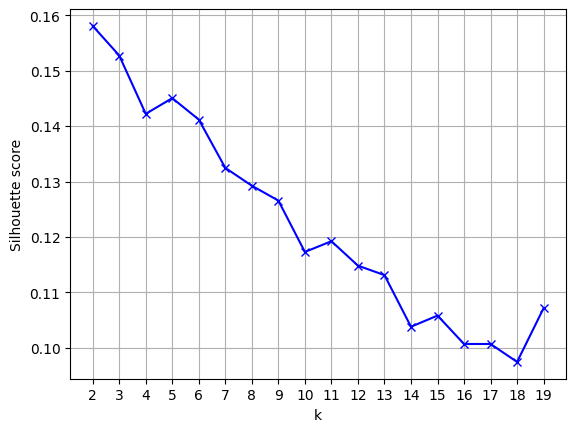

In [405]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k,random_state=42)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores
cluster_num_seq = range(2, 20)
silhouette_vec = count_clustering_scores(df, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.xticks(cluster_num_seq)
plt.grid(True)
plt.show()

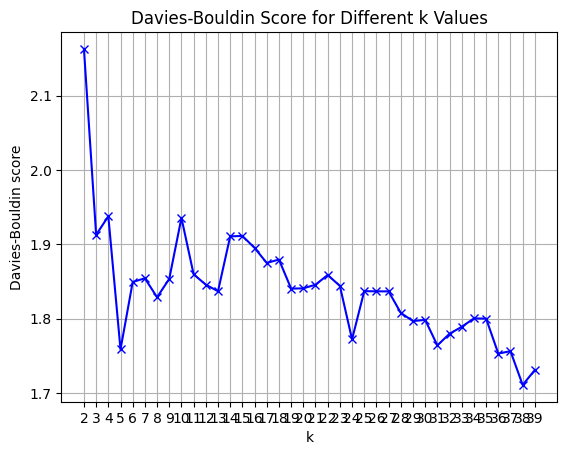

In [406]:
cluster_num_seq = range(2, 40)
#davies_bouldin_vec = count_clustering_scores(df, cluster_num_seq, KMeans, davies_bouldin_score)

davies_bouldin_vec = []
for k in cluster_num_seq:
    kmeans = KMeans(n_clusters=k,random_state=42)
    davies_bouldin_vec.append(davies_bouldin_score(df, kmeans.fit_predict(df)))


plt.plot(cluster_num_seq, davies_bouldin_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin score')
plt.title('Davies-Bouldin Score for Different k Values')
plt.xticks(cluster_num_seq)
plt.grid(True)
plt.show()


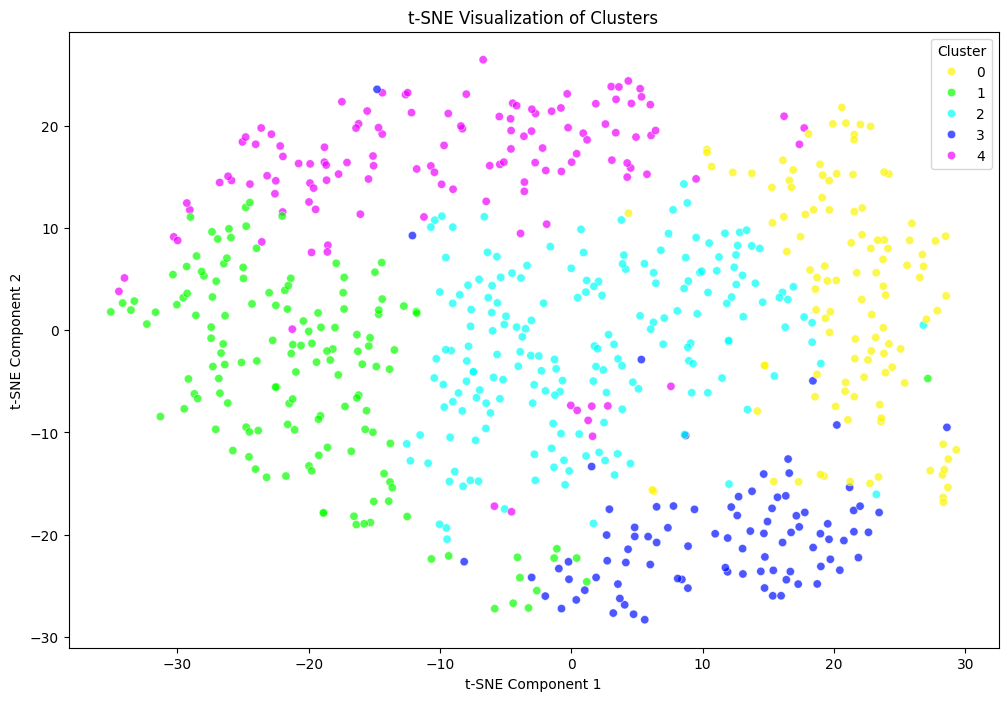

In [402]:
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=14)
clusters = kmeans.fit_predict(df)
tsne_visualization(df,clusters)

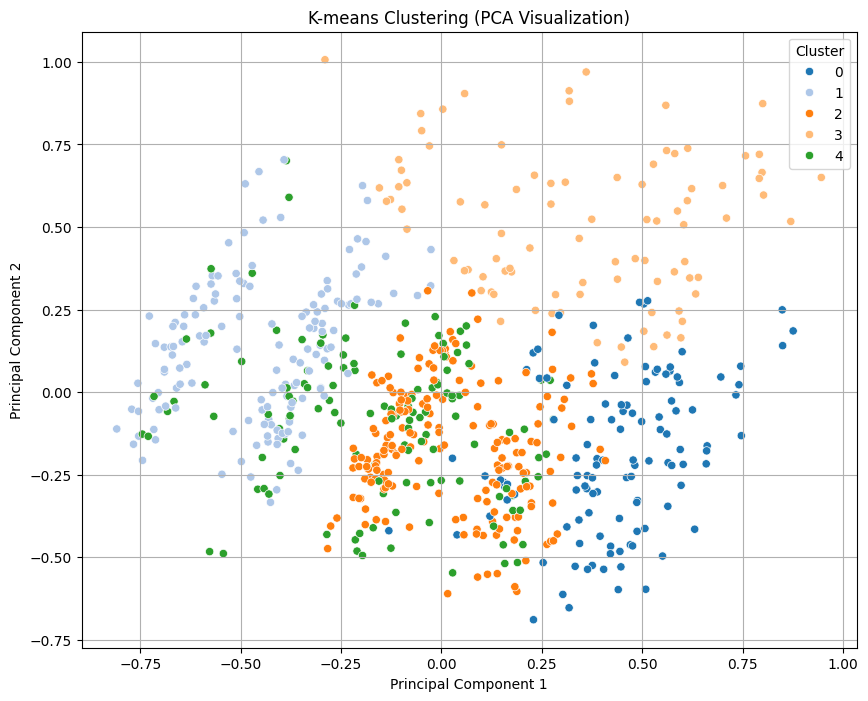

In [403]:
pca_visualization(df,clusters)

In [404]:
metrics(df,kmeans)

[0.1457353489923415, 1.763870491596355, 103.07748859445373]

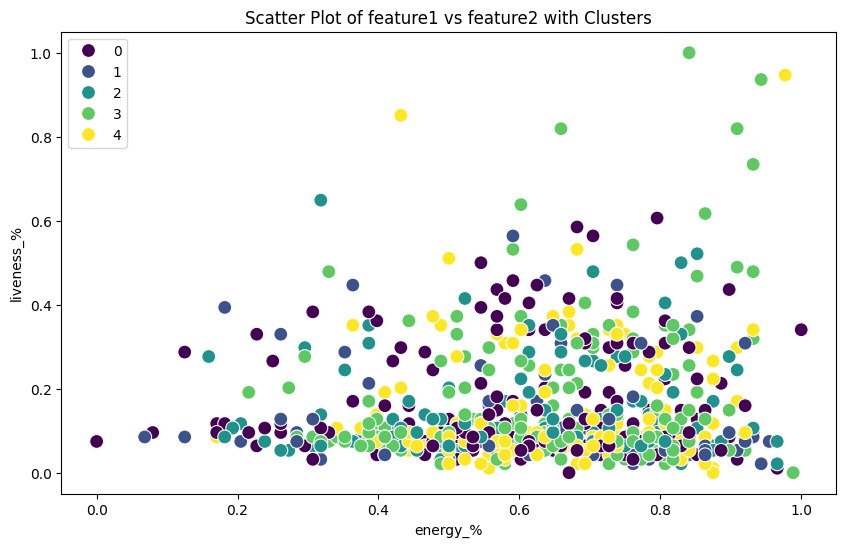

In [363]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='energy_%', y='liveness_%', hue=clusters, palette='viridis', s=100)
plt.title('Scatter Plot of feature1 vs feature2 with Clusters')
plt.show()

In [364]:
df2 = pd.read_csv('../Data/spotify_modelling.csv')
df2['cluster'] = clusters
df2[df2['cluster'] == 3].head(5)

track_name        artist(s)_name  artist_count  \
0                             You Proof         Morgan Wallen             1   
2                      Piï¿½ï¿½man Deï¿  Semicenk, Doï¿½ï¿½u              2   
7                  I Know - PR1SVX Edit        Kanii, PR1ISVX             2   
14  Seven (feat. Latto) (Explicit Ver.)      Latto, Jung Kook             2   
22             Feliz Cumpleaï¿½ï¿½os Fe                  Feid             1   

    released_year  released_month  released_day  in_spotify_playlists  \
0            2022               5            13                  2128   
2            2023               6             2                   185   
7            2023               3            24                   407   
14           2023               7            14                   553   
22           2022               8            19                  3430   

    in_spotify_charts    streams  in_apple_playlists  ...  key   mode  \
0                   9  367814306                  37  ...    A  Major   
2                   3   43522589                   5  ...   A#  Minor   
7                   0   77377503                  16  ...    B  Minor   
14                147  141381703                  43  ...    B  Major   
22                 38  601863821                  45  ...    F  Major   

    danceability_% valence_%  energy_% acousticness_% instrumentalness_%  \
0               73        64        85             25                  0   
2               73        45        62             28                  0   
7               67        11        76              8                 47   
14              80        89        83             31                  0   
22              87        57        55             10                  0   

    liveness_%  speechiness_%  cluster  
0           61              3        3  
2           13             13        3  
7           30              7        3  
14           8              4        3  
22          29              7        3  

[5 rows x 25 columns]

## DBSCAN

For this algorithm we will optimize two params:
- epsilon
- minPts

In [319]:
# function to test given combinations of eps and minPts
def find_best_combination_DBSCAN(epsRange = np.arange(0.2,1.5,0.05), minPtsRange = range(2,10)):
    best_silhouette = [float('-inf'),0,0,0,0]
    best_bouldin = [0,float('inf'),0,0,0]
    best_harabasz = [0,0,float('-inf'),0,0]
    for eps in epsRange:
        for minPts in minPtsRange:
            model = DBSCAN(eps=eps,min_samples=minPts)
            scores = metrics(df,model)
            if(scores[0] > best_silhouette[0]):
                best_silhouette = [scores[0],scores[1],scores[2],eps,minPts]
            if(scores[1] < best_bouldin[1]):
                best_bouldin = [scores[0],scores[1],scores[2],eps,minPts]
            if(scores[2] > best_harabasz[2]):
                best_harabasz = [scores[0],scores[1],scores[2],eps,minPts]

    print("best shilhouette score: "+str(best_silhouette))
    print("best davies-bouldin score"+ str(best_bouldin))
    print('best cialinski-harabasz score'+ str(best_harabasz))
            

In [320]:
find_best_combination_DBSCAN()

best shilhouette score: [0.33876279672862875, 1.453332229612094, 44.06593783199399, 1.3499999999999996, 6]
best davies-bouldin score[-0.012336918150376177, 1.254037305635461, 88.0639219531508, 1.0999999999999999, 9]
best cialinski-harabasz score[0.058764238947753664, 1.8284755419376921, 138.85317502488425, 1.1499999999999997, 9]


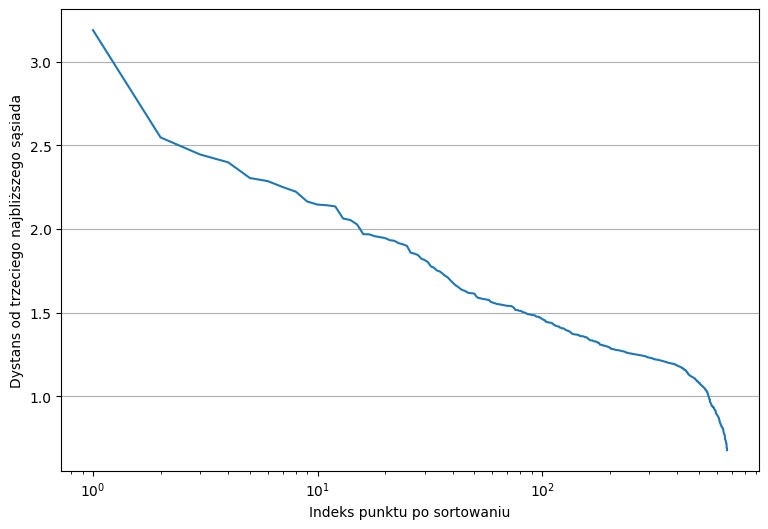

In [365]:
minPts = 20
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(df)
distances, indices = nbrs.kneighbors(df)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,df.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

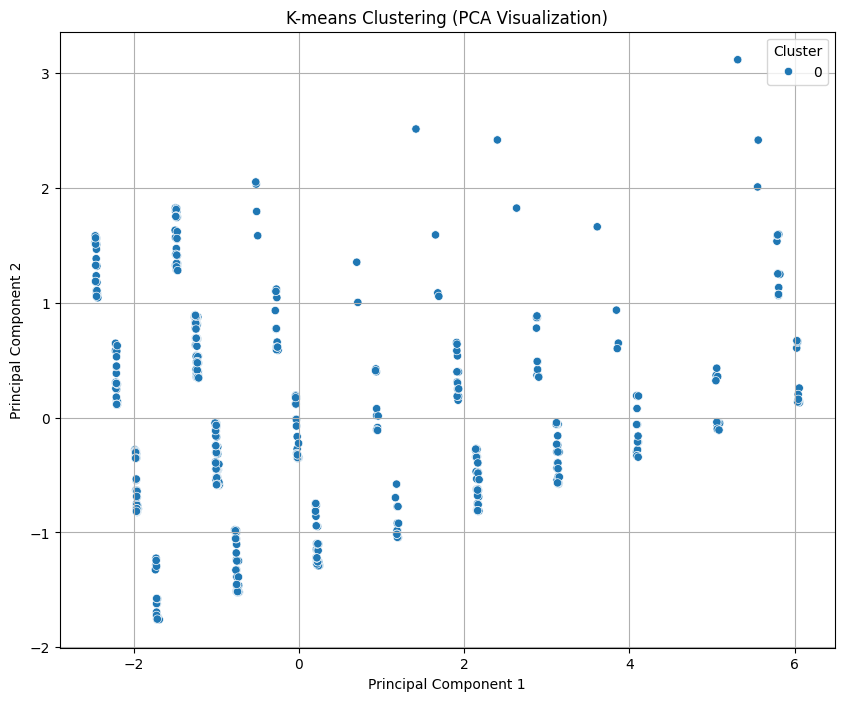

In [369]:
model = DBSCAN(eps = 2.1, min_samples = 10 )
pca_visualization(df,model.fit_predict(df))

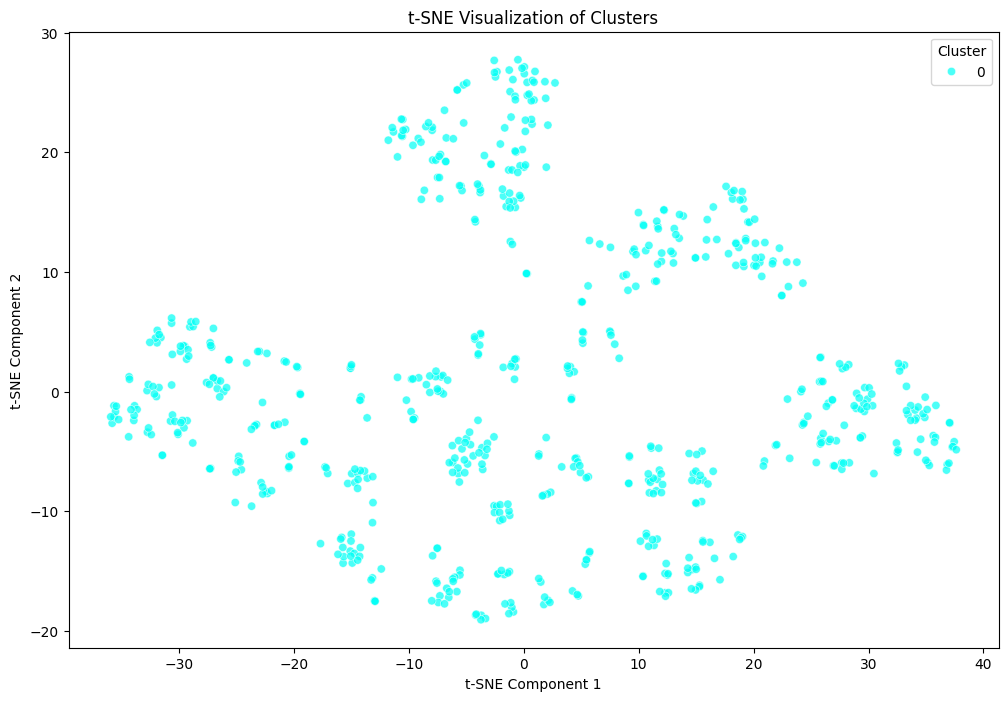

In [327]:
tsne_visualization(df,model.fit_predict(df))

## GMM

## hierarchical